# Analyzing Rat snATAC-seq

## Setup

Get the paths to the files and set our working directory.

In [1]:
sample = "out/qc/Rat_Amygdala_oxycodone_high"

In [2]:
# change to the root directory of the project
setwd('..')

In [3]:
# set the plot sizes to be full width
library(repr)
# Change plot size to BIG
options(repr.plot.width=20, repr.plot.height=10)

Load our dependencies.

Note that this notebook is being run from within a conda environment. You can use our [`env.yml` file](/snATAC/env.yml) to reproduce it.

In [4]:
suppressMessages(library(Signac))
suppressMessages(library(Seurat))
suppressMessages(library(GenomeInfoDb))
# suppressMessages(library(BSgenome.Rnorvegicus.UCSC.rn6))
suppressMessages(library(ggplot2))
suppressMessages(library(patchwork))
suppressMessages(library(AnnotationHub))

Get rat annotations. We use ensemblDB's annotation hub to get this.

In [5]:
EnsDb.Rnorvegicus.v98 = query(AnnotationHub(), pattern = c("Rattus Norvegicus", "EnsDb", 98))[[1]]
# create granges object with TSS positions
# we grab the TSS positions from the reference genome
gene.ranges <- genes(EnsDb.Rnorvegicus.v98)
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding',]
gene.ranges <- keepStandardChromosomes(gene.ranges, pruning.mode = 'coarse', species='Rattus_norvegicus')

using temporary cache /tmp/RtmpPaVih9/BiocFileCache

snapshotDate(): 2020-04-27

downloading 1 resources

retrieving 1 resource

loading from cache

require(“ensembldb”)



## Retrieve QC-ed cells

In [6]:
load(file=paste0(sample,"/cells.rda"))
amygdala

An object of class Seurat 
69428 features across 14128 samples within 1 assay 
Active assay: peaks (69428 features, 0 variable features)

## Normalization and linear dimensional reduction

Run SVD (single value decomposition) to reduce the matrix to a low-dimensional representation. We can use the SVD output to make our UMAP plot. This is like performing PCA prior to t-SNE.

In [7]:
amygdala <- RunTFIDF(amygdala)
amygdala <- FindTopFeatures(amygdala, min.cutoff = 'q0')
amygdala <- RunSVD(
  object = amygdala,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi'
)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



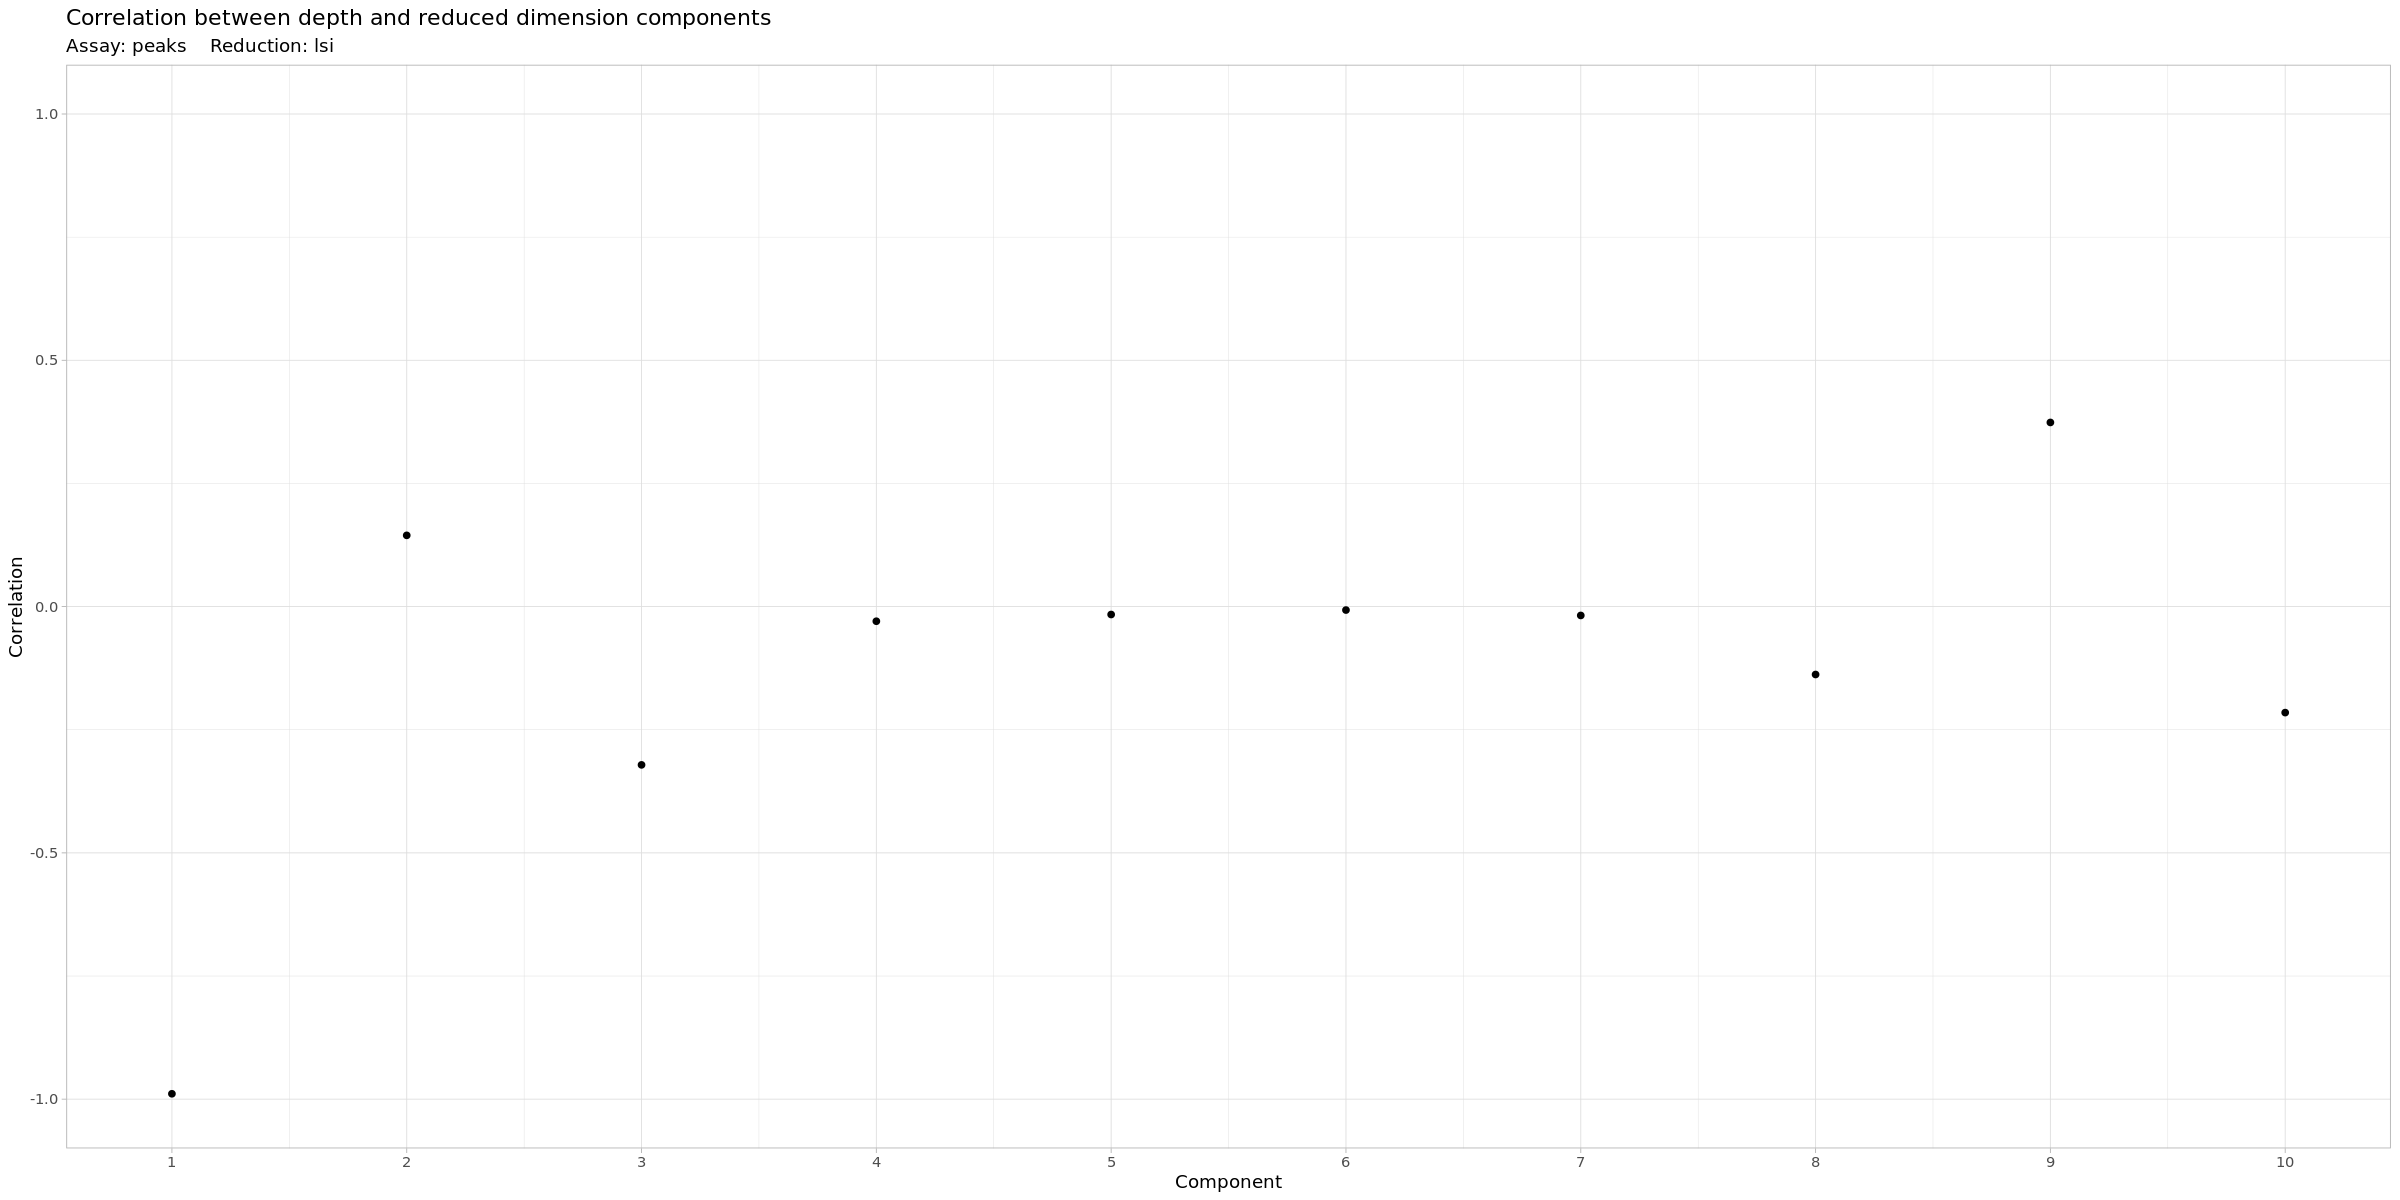

In [8]:
DepthCor(amygdala)

We ignore the first component because it has a high correlation, likely because of technical artifacts.

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
10:26:52 UMAP embedding parameters a = 0.9922 b = 1.112

10:26:53 Read 14128 rows and found 29 numeric columns

10:26:53 Using Annoy for neighbor search, n_neighbors = 30

10:26:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

10:26:56 Writing NN index file to temp file /tmp/RtmpPaVih9/filecba195f389d

10:26:56 Searching Annoy index using 1 thread, search_k = 3000

10:27:02 Annoy recall = 100%

10:27:04 Commencing smooth kNN distance calibration using 1 thread

10:27:06 Initializing fr

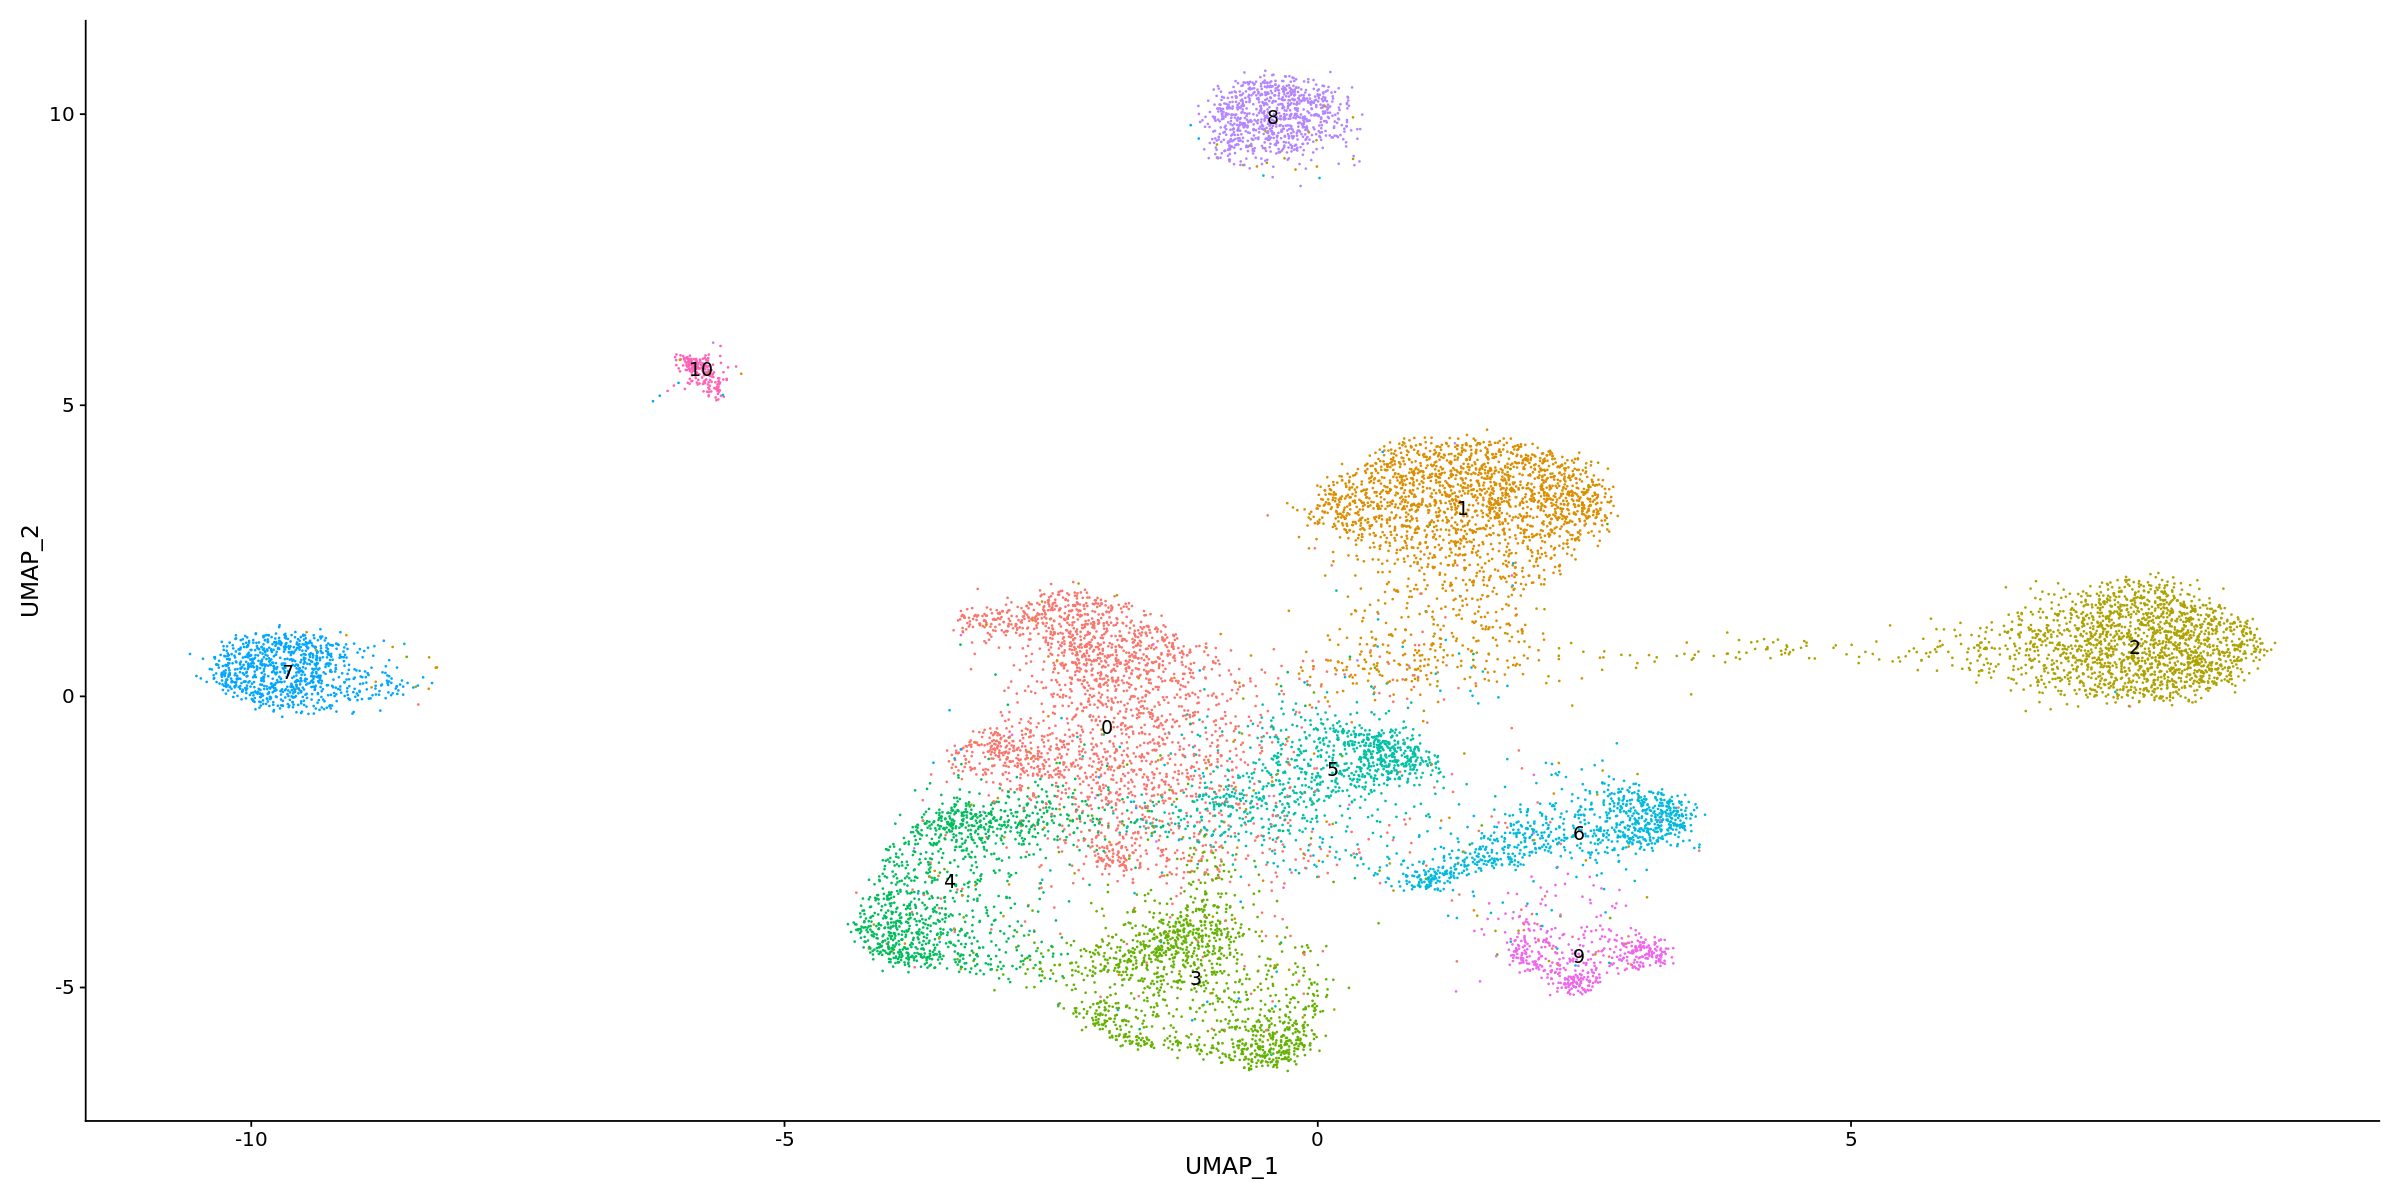

In [9]:
amygdala <- RunUMAP(object = amygdala, reduction = 'lsi', dims = 2:30)
amygdala <- FindNeighbors(object = amygdala, reduction = 'lsi', dims = 2:30)
amygdala <- FindClusters(object = amygdala, verbose = FALSE, algorithm = 3)
DimPlot(object = amygdala, label = TRUE) + NoLegend()

## Create a gene activity matrix

In [ ]:
# Extend coordinates upstream to include the promoter
genebodyandpromoter.coords <- Extend(x = gene.ranges, upstream = 2000, downstream = 0)

# create a gene by cell matrix
gene.activities <- FeatureMatrix(
  fragments = fragment.path,
  features = genebodyandpromoter.coords,
  cells = colnames(amygdala),
  chunk = 20
)

# convert rownames from chromsomal coordinates into gene names
gene.key <- genebodyandpromoter.coords$gene_name
names(gene.key) <- GRangesToString(grange = genebodyandpromoter.coords)
rownames(gene.activities) <- gene.key[rownames(gene.activities)]

In [ ]:
# add the gene activity matrix to the Seurat object as a new assay, and normalize it
amygdala[['RNA']] <- CreateAssayObject(counts = gene.activities)
amygdala <- NormalizeData(
  object = amygdala,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(amygdala$nCount_RNA)
)

In [ ]:
DefaultAssay(amygdala) <- 'RNA'

FeaturePlot(
  object = amygdala,
  features = c('MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)

# Integrating with scRNA-seq data